In [11]:
import business.utils.trading_signals as ts
import business.utils.trading_indicators as ti
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import threading
import concurrent.futures
import logging
import time

stop_flag = threading.Event()
pd.set_option('display.max_columns', None)

DATA_PATH = "data/exports/"
symbol_array = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'ICPUSDT', 'AVAXUSDT']
timeframe_array = ['1m', '15m', '1h', '4h', '1d', '1w']
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [2]:
def calculate_indicators(df, col_prefix):
    """Calculate indicators and add them to the dataframe with a prefix."""
    try:
        # Handle base timeframe (no prefix) and higher timeframes separately
        close_col = f'{col_prefix}_close' if col_prefix else 'close'

        if close_col not in df.columns:
            logging.warning(f"Column {close_col} not found in dataframe. Skipping indicator calculation.")
            return df

        df[f'{col_prefix}_RSI'], df[f'{col_prefix}_RSI_MA'] = ti.calculate_rsi_with_ma(df[close_col], rsi_period=14, ma_type="SMA", ma_length=14)
        df[f'{col_prefix}_MACD'], df[f'{col_prefix}_Signal'], df[f'{col_prefix}_MACD_Hist'] = ti.calculate_macd(df[close_col], fast_period=12, slow_period=26, signal_period=9)
        df[f'{col_prefix}_BB_Mid'], df[f'{col_prefix}_BB_Upper'], df[f'{col_prefix}_BB_Lower'] = ti.calculate_bollinger_bands(df[close_col], window=20, num_std=2)
        df[f'{col_prefix}_Stoch_K'], df[f'{col_prefix}_Stoch_D'] = ti.calculate_stochastic(df, k_period=14, d_period=3)
    
    except Exception as e:
        logging.error(f"Error calculating indicators for {col_prefix or 'base timeframe'}: {e}")

    return df


In [3]:
# Function to process each dataset
def process_symbol_timeframe(symbol, timeframe):
    """Processes a specific symbol and timeframe by computing all indicators."""
    
    if stop_flag.is_set():
        return
    file_path = os.path.join(DATA_PATH, f"{symbol}_{timeframe}_data.csv")
    if not os.path.exists(file_path):
        logging.warning(f"File {file_path} does not exist. Skipping.")
        return
    start_time = time.time()
    logging.info(f"Processing {symbol} on {timeframe} timeframe...")
    df = pd.read_csv(file_path, parse_dates=['timestamp'])
    df = calculate_indicators(df, "")
    for ht in ['15m', '1h', '4h', '1d', '1w']:
        if f"{ht}_close" in df.columns:
            df = calculate_indicators(df, ht)
    df.to_csv(file_path, index=False)
    logging.info(f"Completed {symbol} on {timeframe} in {time.time() - start_time:.2f}s")


In [4]:
def run_processing():
    """Runs multi-threaded processing for all symbols and timeframes."""
    global stop_flag
    stop_flag.clear()  # Ensure flag is not set before starting
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=4, thread_name_prefix="Worker") as executor:
            futures = []
            for symbol in symbol_array:
                for timeframe in timeframe_array:
                    if stop_flag.is_set():
                        break  # Stop if requested
                    futures.append(executor.submit(process_symbol_timeframe, symbol, timeframe))
            
            # Wait for all threads to complete unless stop_flag is set
            for future in concurrent.futures.as_completed(futures):
                if stop_flag.is_set():
                    break
                future.result()

In [5]:
run_processing()

2025-03-15 14:45:56,561 - INFO - Processing BTCUSDT on 1m timeframe...
2025-03-15 14:45:58,097 - INFO - Processing BTCUSDT on 15m timeframe...
2025-03-15 14:46:01,663 - INFO - Processing BTCUSDT on 1h timeframe...
2025-03-15 14:46:04,986 - INFO - Processing BTCUSDT on 4h timeframe...
2025-03-15 14:46:24,494 - INFO - Completed BTCUSDT on 4h in 19.51s
2025-03-15 14:47:08,707 - INFO - Processing BTCUSDT on 1d timeframe...
2025-03-15 14:47:08,713 - INFO - Completed BTCUSDT on 1h in 67.05s
2025-03-15 14:47:09,765 - INFO - Processing BTCUSDT on 1w timeframe...
2025-03-15 14:47:12,548 - INFO - Completed BTCUSDT on 1w in 2.78s
2025-03-15 14:47:17,015 - INFO - Processing ETHUSDT on 1m timeframe...
2025-03-15 14:47:19,290 - INFO - Completed BTCUSDT on 1d in 10.58s
2025-03-15 14:47:21,425 - INFO - Processing ETHUSDT on 15m timeframe...
2025-03-15 14:48:11,966 - INFO - Completed BTCUSDT on 15m in 133.87s
2025-03-15 14:48:21,839 - INFO - Processing ETHUSDT on 1h timeframe...
2025-03-15 14:48:55,231

In [9]:
df = pd.read_csv('data/exports/ETHUSDT_1m_data.csv', parse_dates=['timestamp'])

In [12]:
print(df.columns)
df.tail(20)

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'ignore', '15m_open', '15m_high',
       '15m_low', '15m_close', '1h_open', '1h_high', '1h_low', '1h_close',
       '4h_open', '4h_high', '4h_low', '4h_close', '1d_open', '1d_high',
       '1d_low', '1d_close', '1w_open', '1w_high', '1w_low', '1w_close',
       '_RSI', '_RSI_MA', '_MACD', '_Signal', '_MACD_Hist', '_BB_Mid',
       '_BB_Upper', '_BB_Lower', '_Stoch_K', '_Stoch_D', '15m_RSI',
       '15m_RSI_MA', '15m_MACD', '15m_Signal', '15m_MACD_Hist', '15m_BB_Mid',
       '15m_BB_Upper', '15m_BB_Lower', '15m_Stoch_K', '15m_Stoch_D', '1h_RSI',
       '1h_RSI_MA', '1h_MACD', '1h_Signal', '1h_MACD_Hist', '1h_BB_Mid',
       '1h_BB_Upper', '1h_BB_Lower', '1h_Stoch_K', '1h_Stoch_D', '4h_RSI',
       '4h_RSI_MA', '4h_MACD', '4h_Signal', '4h_MACD_Hist', '4h_BB_Mid',
       '4h_BB_Upper', '4h_BB_Lowe

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,15m_open,15m_high,15m_low,15m_close,1h_open,1h_high,1h_low,1h_close,4h_open,4h_high,4h_low,4h_close,1d_open,1d_high,1d_low,1d_close,1w_open,1w_high,1w_low,1w_close,_RSI,_RSI_MA,_MACD,_Signal,_MACD_Hist,_BB_Mid,_BB_Upper,_BB_Lower,_Stoch_K,_Stoch_D,15m_RSI,15m_RSI_MA,15m_MACD,15m_Signal,15m_MACD_Hist,15m_BB_Mid,15m_BB_Upper,15m_BB_Lower,15m_Stoch_K,15m_Stoch_D,1h_RSI,1h_RSI_MA,1h_MACD,1h_Signal,1h_MACD_Hist,1h_BB_Mid,1h_BB_Upper,1h_BB_Lower,1h_Stoch_K,1h_Stoch_D,4h_RSI,4h_RSI_MA,4h_MACD,4h_Signal,4h_MACD_Hist,4h_BB_Mid,4h_BB_Upper,4h_BB_Lower,4h_Stoch_K,4h_Stoch_D,1d_RSI,1d_RSI_MA,1d_MACD,1d_Signal,1d_MACD_Hist,1d_BB_Mid,1d_BB_Upper,1d_BB_Lower,1d_Stoch_K,1d_Stoch_D,1w_RSI,1w_RSI_MA,1w_MACD,1w_Signal,1w_MACD_Hist,1w_BB_Mid,1w_BB_Upper,1w_BB_Lower,1w_Stoch_K,1w_Stoch_D
3239628,2025-03-02 14:19:00,2178.63,2182.30,2172.04,2180.69,3158.7793,1740925199999,6.877267e+06,10297,1466.1835,3.191613e+06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.806690,28.967902,-7.427817,-4.689385,-2.738432,2202.0380,2223.943504,2180.132496,22.202259,9.398880,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,22.202259,9.398880,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,22.202259,9.398880,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,22.202259,9.398880,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,22.202259,9.398880,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,22.202259,9.398880
3239629,2025-03-02 14:20:00,2180.69,2185.09,2178.43,2183.99,734.7473,1740925259999,1.603471e+06,4650,387.7385,8.461354e+05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.188839,27.930985,-7.636291,-5.278767,-2.357524,2200.5880,2223.266655,2177.909345,32.314765,18.172341,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,32.314765,18.172341,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,32.314765,18.172341,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,32.314765,18.172341,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,32.314765,18.172341,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,32.314765,18.172341
3239630,2025-03-02 14:21:00,2184.00,2185.99,2183.09,2185.01,510.0171,1740925319999,1.114156e+06,3868,258.7906,5.653192e+05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.357077,27.610205,-7.631234,-5.749260,-1.881974,2199.2105,2222.172353,2176.248647,38.191991,30.903005,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,38.191991,30.903005,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,38.191991,30.903005,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,38.191991,30.903005,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,38.191991,30.903005,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,38.191991,30.903005
3239631,2025-03-02 14:22:00,2185.00,2188.03,2183.18,2186.91,1206.8899,1740925379999,2.637818e+06,4172,955.9872,2.089446e+06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.343925,27.554556,-7.388740,-6.077156,-1.311584,2198.0940,2221.173733,2175.014267,43.786808,38.097854,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,43.786808,38.097854,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,43.786808,38.097854,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,43.786808,38.097854,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,43.786808,38.097854,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,43.786808,38.097854
3239632,2025-03-02 14:23:00,2186.90,2188.89,2185.56,2187.00,570.5191,1740925439999,1.247943e+06,3969,283.2496,6.196019e+05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.535441,27.321576,-7.107370,-6.283199,-0.824171,2196.7840,2219.218773,2174.349227,44.051826,42.010208,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,44.051826,42.010208,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,44.051826,42.010208,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,44.051826,42.010208,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,44.051826,42.010208,NaN,NaN,-0.0952,-0.0952,0.0,NaN,NaN,NaN,44.051826,42.010208
3239633,2025-03-02 14:24:00,21

In [6]:
df['RSI'], df['RSI_MA'] = ti.calculate_rsi_with_ma(df['close'], rsi_period=14, ma_type="SMA", ma_length=14)
df['MACD'], df['Signal'], df['MACD_Hist'] = ti.calculate_macd(df['close'], fast_period=12, slow_period=26, signal_period=9)
df['BB_Mid'], df['BB_Upper'], df['BB_Lower'] = ti.calculate_bollinger_bands(df['close'], window=20, num_std=2)
df['Stoch_K'], df['Stoch_D'] = ti.calculate_stochastic(df, k_period=14, d_period=3)

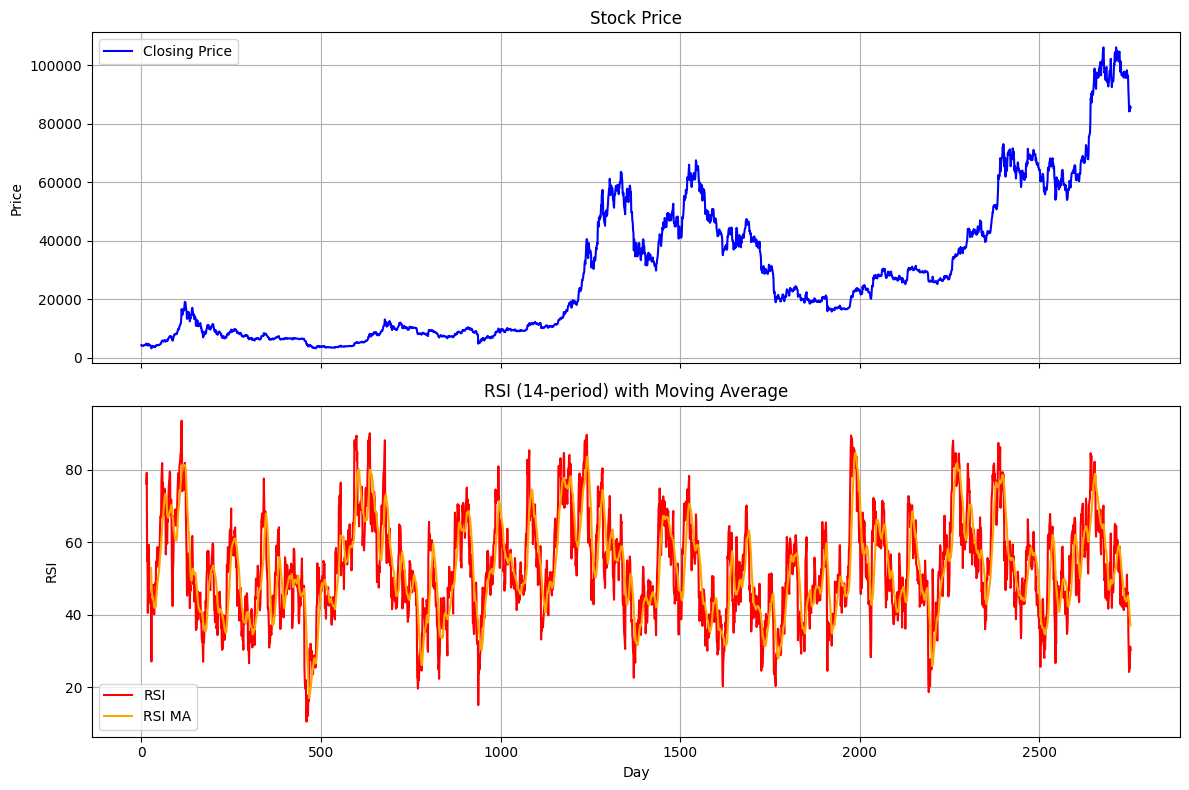

In [7]:

# Create subplots: one for the price and one for the RSI and its MA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top subplot: Plot the closing prices
ax1.plot(df.index, df['close'], label='Closing Price', color='blue')
ax1.set_ylabel('Price')
ax1.set_title('Stock Price')
ax1.legend()
ax1.grid(True)

# Bottom subplot: Plot the RSI and its moving average
ax2.plot(df.index, df['RSI'], label='RSI', color='red')
ax2.plot(df.index, df['RSI_MA'], label='RSI MA', color='orange')
ax2.set_ylabel('RSI')
ax2.set_xlabel('Day')
ax2.set_title('RSI (14-period) with Moving Average')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlapping and display the plot
plt.tight_layout()
plt.show()

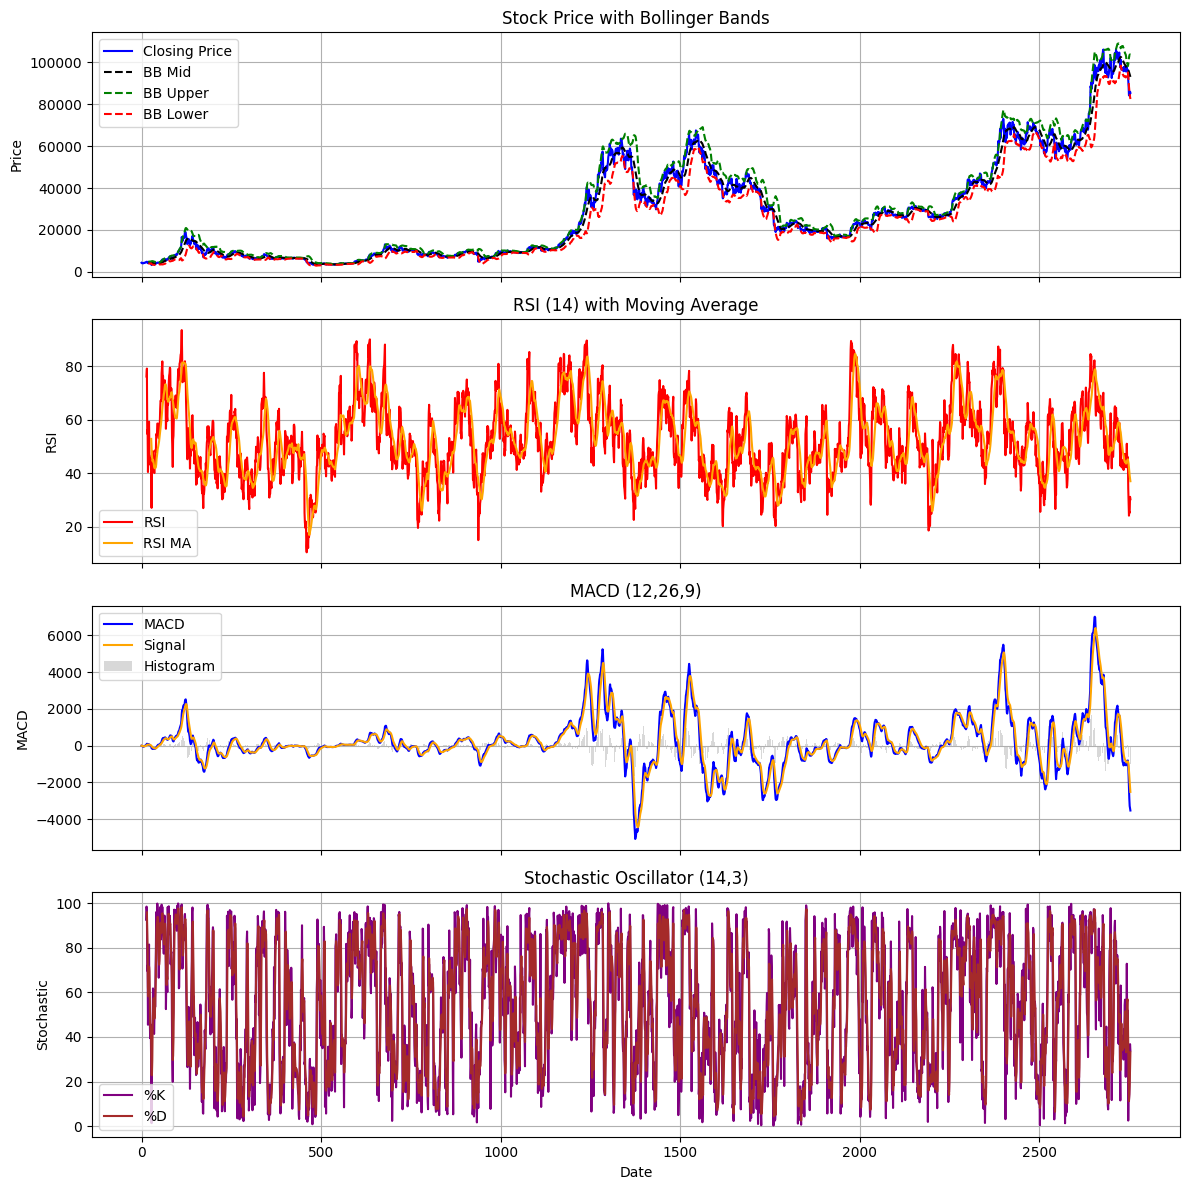

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# --- Panel 1: Price with Bollinger Bands ---
ax1.plot(df.index, df['close'], label='Closing Price', color='blue')
ax1.plot(df.index, df['BB_Mid'], label='BB Mid', color='black', linestyle='--')
ax1.plot(df.index, df['BB_Upper'], label='BB Upper', color='green', linestyle='--')
ax1.plot(df.index, df['BB_Lower'], label='BB Lower', color='red', linestyle='--')
ax1.set_ylabel('Price')
ax1.set_title('Stock Price with Bollinger Bands')
ax1.legend()
ax1.grid(True)

# --- Panel 2: RSI with its Moving Average ---
ax2.plot(df.index, df['RSI'], label='RSI', color='red')
ax2.plot(df.index, df['RSI_MA'], label='RSI MA', color='orange')
ax2.set_ylabel('RSI')
ax2.set_title('RSI (14) with Moving Average')
ax2.legend()
ax2.grid(True)

# --- Panel 3: MACD ---
ax3.plot(df.index, df['MACD'], label='MACD', color='blue')
ax3.plot(df.index, df['Signal'], label='Signal', color='orange')
# Plot histogram as bars
ax3.bar(df.index, df['MACD_Hist'], label='Histogram', color='grey', alpha=0.3)
ax3.set_ylabel('MACD')
ax3.set_title('MACD (12,26,9)')
ax3.legend()
ax3.grid(True)

# --- Panel 4: Stochastic Oscillator ---
ax4.plot(df.index, df['Stoch_K'], label='%K', color='purple')
ax4.plot(df.index, df['Stoch_D'], label='%D', color='brown')
ax4.set_ylabel('Stochastic')
ax4.set_title('Stochastic Oscillator (14,3)')
ax4.set_xlabel('Date')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()